# Chapter 5. Multivariate Linear Models

In [1]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

from rethinking import (LM, MAP, coef, extract_samples, glimmer,
                        link, precis, replicate, sim, vcov)

### Code 5.1

In [2]:
# load data
waffle_divorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = waffle_divorce

# standardize predictor
median_age_marriage = torch.tensor(d["MedianAgeMarriage"], dtype=torch.float)
median_age_marriage_s = ((median_age_marriage - median_age_marriage.mean())
                         / median_age_marriage.std())

# fit model
def model(median_age_marriage, divorce):
    a = pyro.sample("a", dist.Normal(10, 10))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    mu = a + bA * median_age_marriage
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("Divorce", dist.Normal(mu, sigma), obs=divorce)

divorce = torch.tensor(d["Divorce"], dtype=torch.float)
m5_1 = MAP(model).run(median_age_marriage_s, divorce)

### Code 5.2

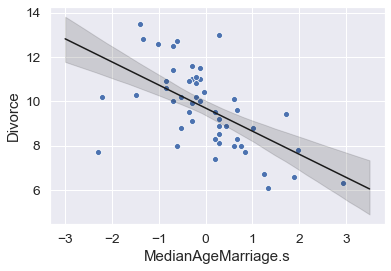

In [3]:
# compute percentile interval of mean
MAM_seq = torch.linspace(start=-3, end=3.5, steps=30)
mu = link(m5_1, data={"median_age_marriage": MAM_seq})
mu_PI = stats.pi(mu, 0.89, dim=0)

# plot it all
ax = sns.scatterplot(median_age_marriage_s, divorce)
ax.set(xlabel="MedianAgeMarriage.s", ylabel="Divorce")
x = torch.linspace(-3, 3.5, 101)
sns.lineplot(x, coef(m5_1)["a"] + coef(m5_1)["bA"] * x, color="k")
ax.fill_between(MAM_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.15);

### Code 5.3

In [3]:
def model(marriage, divorce):
    a = pyro.sample("a", dist.Normal(10, 10))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    mu = a + bR * marriage
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("Divorce", dist.Normal(mu, sigma), obs=divorce)

marriage = torch.tensor(d["Marriage"], dtype=torch.float)
marriage_s = (marriage - marriage.mean()) / marriage.std()
m5_2 = MAP(model).run(marriage_s, divorce)

### Code 5.4

In [4]:
def model(marriage, median_age_marriage, divorce):
    a = pyro.sample("a", dist.Normal(10, 10))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    mu = a + bR * marriage + bA * median_age_marriage
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("Divorce", dist.Normal(mu, sigma), obs=divorce)

m5_3 = MAP(model).run(marriage_s, median_age_marriage_s, divorce)
precis(m5_3)

,Mean,StdDev,|0.89,0.89|
a,9.69,0.20,9.38,10.04
bR,-0.13,0.28,-0.57,0.32
bA,-1.14,0.28,-1.58,-0.69
sigma,1.46,0.15,1.22,1.68


### Code 5.5

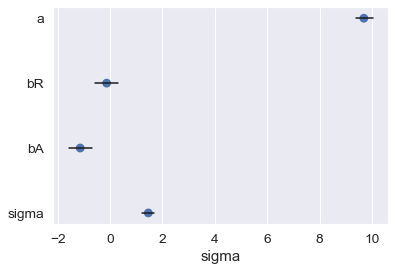

In [9]:
precis_df = precis(m5_3)
sns.pointplot(precis_df["Mean"], precis_df.index, join=False)
for i, node in enumerate(precis_df.index):
    sns.lineplot(precis_df.loc[node, ["|0.89", "0.89|"]], [i, i], color="k")

### Code 5.6

In [10]:
def model(median_age_marriage, marriage):
    a = pyro.sample("a", dist.Normal(10, 10))
    b = pyro.sample("b", dist.Normal(0, 1))
    mu = a + b * median_age_marriage
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("outcome", dist.Normal(mu, sigma), obs=marriage_s)

m5_4 = MAP(model).run(median_age_marriage_s, marriage_s)

### Code 5.7

In [11]:
# compute expected value at MAP, for each State
mu = coef(m5_4)["a"] + coef(m5_4)["b"] * median_age_marriage_s
# compute residual for each State
m_resid = marriage_s - mu

### Code 5.8

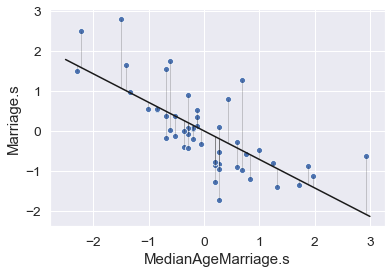

In [12]:
ax = sns.scatterplot(median_age_marriage_s, marriage_s)
ax.set(xlabel="MedianAgeMarriage.s", ylabel="Marriage.s")
x = torch.linspace(-2.5, 3, 101)
sns.lineplot(x, coef(m5_4)["a"] + coef(m5_4)["b"] * x, color="k")
# loop over States
for i in range(len(m_resid)):
    x = median_age_marriage_s[i]  # x location of line segment
    y = marriage_s[i]  # observed endpoint of line segment
    # draw the line segment
    sns.lineplot(x.repeat(2), torch.stack([mu[i], y]), color="k", alpha=0.7)

### Code 5.9

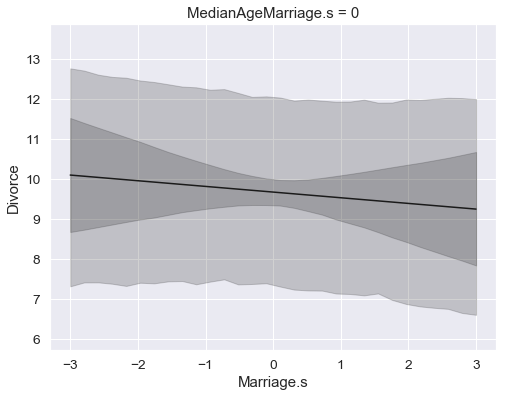

In [10]:
# prepare new counterfactual data
A_avg = median_age_marriage_s.mean()
R_seq = torch.linspace(start=-3, end=3, steps=30)
pred_data = {"marriage": R_seq, "median_age_marriage": A_avg.expand_as(R_seq)}

# compute counterfactual mean divorce (mu)
mu = link(m5_3, data=pred_data)
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, 0.89, dim=0)

# simulate counterfactual divorce outcomes
R_sim = sim(m5_3, data=pred_data, n=int(1e4))
R_PI = stats.pi(R_sim, 0.89, dim=0)

# display predictions, hiding raw data with visible=False
ax = sns.scatterplot(marriage_s, divorce, visible=False)
ax.set(xlabel="Marriage.s", ylabel="Divorce", title="MedianAgeMarriage.s = 0")
sns.lineplot(R_seq, mu_mean, color="k")
ax.fill_between(R_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.fill_between(R_seq, R_PI[0], R_PI[1], color="k", alpha=0.2);

### Code 5.10

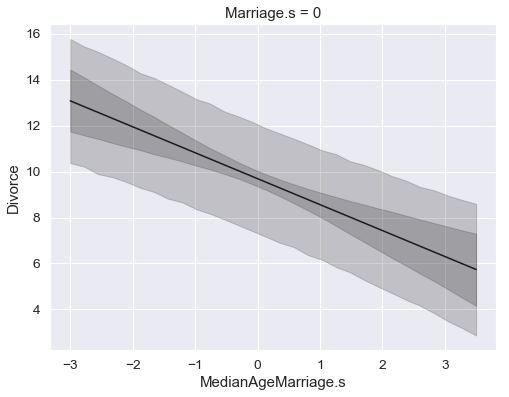

In [11]:
R_avg = marriage_s.mean()
A_seq = torch.linspace(start=-3, end=3.5, steps=30)
pred_data2 = {"marriage": R_avg.expand_as(A_seq), "median_age_marriage": A_seq}

mu = link(m5_3, data=pred_data2)
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, 0.89, dim=0)

A_sim = sim(m5_3, data=pred_data2, n=int(1e4))
A_PI = stats.pi(A_sim, 0.89, dim=0)

ax = sns.scatterplot(median_age_marriage_s, divorce, visible=False)
ax.set(xlabel="MedianAgeMarriage.s", ylabel="Divorce", title="Marriage.s = 0")
sns.lineplot(A_seq, mu_mean, color="k")
ax.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.fill_between(A_seq, A_PI[0], A_PI[1], color="k", alpha=0.2);

### Code 5.11

In [12]:
# call link without specifying new data
# so it uses original data
mu = link(m5_3)

# summarize samples across cases
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, 0.89, dim=0)

# simulate observations
# again no new data, so uses original data
divorce_sim = sim(m5_3, n=int(1e4))
divorce_PI = stats.pi(divorce_sim, 0.89, dim=0)

### Code 5.12

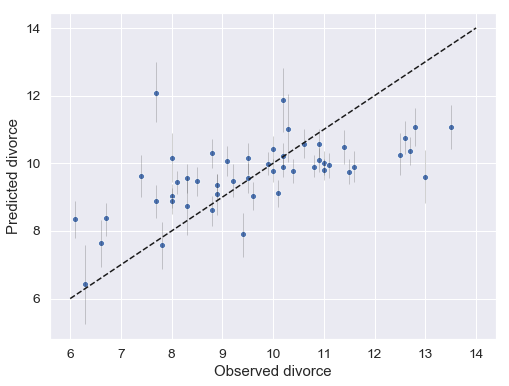

In [13]:
fig, ax = sns.mpl.pyplot.subplots()
sns.scatterplot(divorce, mu_mean)
ax.set(xlabel="Observed divorce", ylabel="Predicted divorce")
x = torch.linspace(6, 14, 101)
sns.lineplot(x, x, color="k")
ax.lines[-1].set_linestyle("--")
for i in range(d.shape[0]):
    sns.lineplot(divorce[i].repeat(2), mu_PI[:, i], color="k")

### Code 5.13

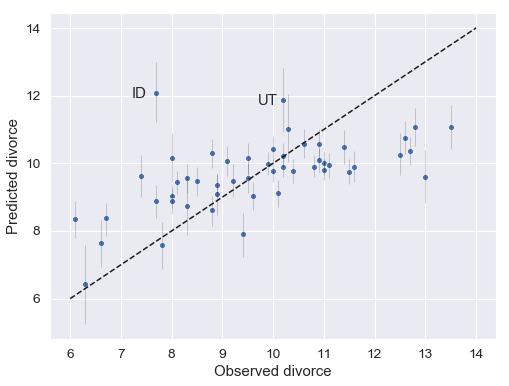

In [14]:
identify = mu_mean.sort(descending=True)[1][:2]
for i in identify:
    ax.annotate(d["Loc"][i], (divorce[i], mu_mean[i]), xytext=(-25, -5),
                textcoords="offset pixels")
fig

### Code 5.14

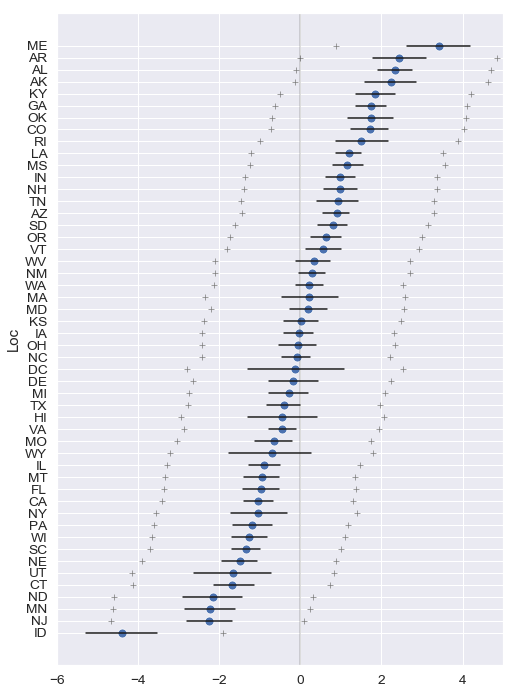

In [15]:
# compute residuals
divorce_resid = divorce - mu_mean
# get ordering by divorce rate
o = divorce_resid.sort()[1].tolist()
# make the plot
_, ax = sns.mpl.pyplot.subplots(figsize=(8, 12))
sns.scatterplot(divorce_resid[o], d["Loc"][o], s=80)
ax.set(xlim=(-6, 5))
ax.yaxis.grid(True)
ax.axvline(x=0, c="k", alpha=0.2)
for i in range(d.shape[0]):
    j = o[i]  # which State in order
    sns.lineplot(divorce[j] - mu_PI[:, j], [i, i], color="k")
    sns.scatterplot(divorce[j] - divorce_PI[:, j], [i, i], color="gray", marker="+")

### Code 5.15

In [16]:
N = 100  # number of cases
x_real = torch.randn(N)  # x_real as Gaussian with mean 0 and stddev 1
x_spur = dist.Normal(x_real, 1).sample()  # x_spur as Gaussian with mean=x_real
y = dist.Normal(x_real, 1).sample()  # y as Gaussian with mean=x_real
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

### Code 5.16

In [17]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
clade             29 non-null object
species           29 non-null object
kcal.per.g        29 non-null float64
perc.fat          29 non-null float64
perc.protein      29 non-null float64
perc.lactose      29 non-null float64
mass              29 non-null float64
neocortex.perc    17 non-null float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.17

In [18]:
def model(neocortex_perc, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0, 100))
    bn = pyro.sample("bn", dist.Normal(0, 1))
    mu = a + bn * neocortex_perc
    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

# fit model
neocortex_perc = torch.tensor(d["neocortex.perc"], dtype=torch.float)
kcal_per_g = torch.tensor(d["kcal.per.g"], dtype=torch.float)
try:
    m5_5 = MAP(model).run(neocortex_perc, kcal_per_g)
except Exception as e:
    print("{}: {}".format(type(e).__name__, e))

ValueError: The parameter loc has invalid values
Trace Shapes:  
 Param Sites:  
Sample Sites:  
       a dist |
        value |
      bn dist |
        value |
   sigma dist |
        value |


### Code 5.18

In [19]:
neocortex_perc

tensor([55.1600,     nan,     nan,     nan,     nan, 64.5400, 64.5400, 67.6400,
            nan, 68.8500, 58.8500, 61.6900, 60.3200,     nan,     nan, 69.9700,
            nan, 70.4100,     nan, 73.4000,     nan, 67.5300,     nan, 71.2600,
        72.6000,     nan, 70.2400, 76.3000, 75.4900])

### Code 5.19

In [20]:
isnan = torch.isnan(neocortex_perc)
dcc_neocortex_perc = neocortex_perc[~isnan]
dcc_kcal_per_g = kcal_per_g[~isnan]

### Code 5.20

In [21]:
def model(neocortex_perc, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0, 100))
    bn = pyro.sample("bn", dist.Normal(0, 1))
    mu = a + bn * neocortex_perc
    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_5 = MAP(model).run(dcc_neocortex_perc, dcc_kcal_per_g)

### Code 5.21

In [22]:
precis(m5_5, digits=3)

,Mean,StdDev,|0.89,0.89|
a,0.355,0.481,-0.386,1.139
bn,0.004,0.007,-0.007,0.015
sigma,0.172,0.030,0.123,0.218


### Code 5.22

In [23]:
coef(m5_5)["bn"] * (76 - 55)

tensor(0.0940)

### Code 5.23

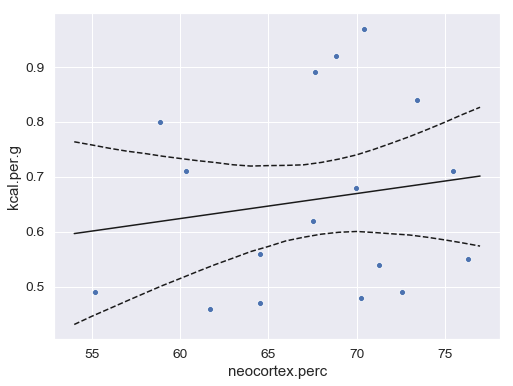

In [24]:
np_seq = torch.arange(100.)
pred_data = {"neocortex_perc": np_seq}

mu = link(m5_5, data=pred_data, n=int(1e4))
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, 0.89, dim=0)

ax = sns.scatterplot(dcc_neocortex_perc, dcc_kcal_per_g)
ax.set(xlabel="neocortex.perc", ylabel="kcal.per.g")
sns.lineplot(np_seq[54:78], mu_mean[54:78], color="k")
sns.lineplot(np_seq[54:78], mu_PI[0, 54:78], color="k")
ax.lines[-1].set_linestyle("--")
sns.lineplot(np_seq[54:78], mu_PI[1, 54:78], color="k")
ax.lines[-1].set_linestyle("--")

### Code 5.24

In [25]:
mass = torch.tensor(d["mass"], dtype=torch.float)
dcc_mass = mass[~isnan]
dcc_log_mass = dcc_mass.log()

### Code 5.25

In [26]:
def model(log_mass, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0, 100))
    bm = pyro.sample("bn", dist.Normal(0, 1))
    mu = a + bm * log_mass
    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_6 = MAP(model).run(dcc_log_mass, dcc_kcal_per_g)
precis(m5_6)

,Mean,StdDev,|0.89,0.89|
a,0.71,0.05,0.63,0.78
bn,-0.03,0.02,-0.06,0.00
sigma,0.16,0.03,0.12,0.20


### Code 5.26

In [27]:
def model(neocortex_perc, log_mass, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0, 100))
    bn = pyro.sample("bn", dist.Normal(0, 1))
    bm = pyro.sample("bm", dist.Normal(0, 1))
    mu = a + bn * neocortex_perc + bm * log_mass
    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_7 = MAP(model).run(dcc_neocortex_perc, dcc_log_mass, dcc_kcal_per_g)
precis(m5_7)

,Mean,StdDev,|0.89,0.89|
a,-1.09,0.47,-1.84,-0.32
bn,0.03,0.01,0.02,0.04
bm,-0.10,0.02,-0.14,-0.06
sigma,0.12,0.02,0.09,0.15


### Code 5.27

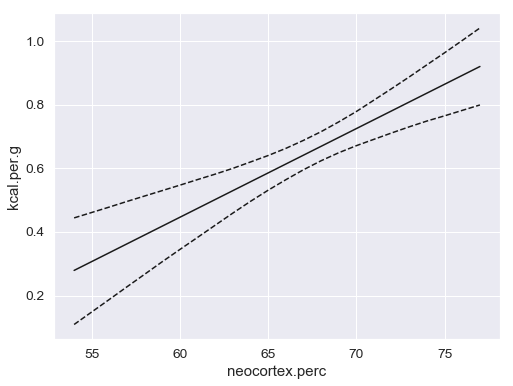

In [28]:
mean_log_mass = dcc_log_mass.mean()
np_seq = torch.arange(100.)
pred_data = {"neocortex_perc": np_seq, "log_mass": mean_log_mass.expand_as(np_seq)}

mu = link(m5_7, data=pred_data, n=int(1e4))
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, 0.89, dim=0)

ax = sns.scatterplot(dcc_neocortex_perc, dcc_kcal_per_g, visible=False)
ax.set(xlabel="neocortex.perc", ylabel="kcal.per.g")
sns.lineplot(np_seq[54:78], mu_mean[54:78], color="k")
sns.lineplot(np_seq[54:78], mu_PI[0, 54:78], color="k")
ax.lines[-1].set_linestyle("--")
sns.lineplot(np_seq[54:78], mu_PI[1, 54:78], color="k")
ax.lines[-1].set_linestyle("--")

### Code 5.28

In [29]:
N = 100  # number of cases
rho = 0.7  # correlation btw x_pos and x_neg
x_pos = torch.randn(N)  # x_pos as Gaussian
# x_neg correlated with x_pos
x_neg = dist.Normal(rho * x_pos, (1 - rho**2) ** 0.5).sample()
y = dist.Normal(x_pos - x_neg, 1).sample()  # y equally associated with x_pos, x_neg
d = pd.DataFrame({"y": y, "x_pos": x_pos, "x_neg": x_neg})

### Code 5.29

In [30]:
N = 100  # number of individuals
height = torch.empty(N).normal_(10, 2)  # sim total height of each
leg_prop = torch.empty(N).uniform_(0.4, 0.5)  # leg as proportion of height
# sim left leg as proportion + error
leg_left = leg_prop * height + torch.empty(N).normal_(0, 0.02)
# sim right leg as proportion + error
leg_right = leg_prop * height + torch.empty(N).normal_(0, 0.02)
# combine into data dict
d = {"height": height, "leg_left": leg_left, "leg_right": leg_right}

### Code 5.30

In [31]:
def model(leg_left, leg_right, height):
    a = pyro.sample("a", dist.Normal(10, 100))
    bl = pyro.sample("bl", dist.Normal(2, 10))
    br = pyro.sample("br", dist.Normal(2, 10))
    mu = a + bl * leg_left + br * leg_right
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_8 = MAP(model).run(**d)
precis(m5_8)

,Mean,StdDev,|0.89,0.89|
a,1.10,0.32,0.58,1.61
bl,0.82,2.07,-2.46,4.15
br,1.16,2.06,-2.13,4.46
sigma,0.65,0.05,0.58,0.72


### Code 5.31

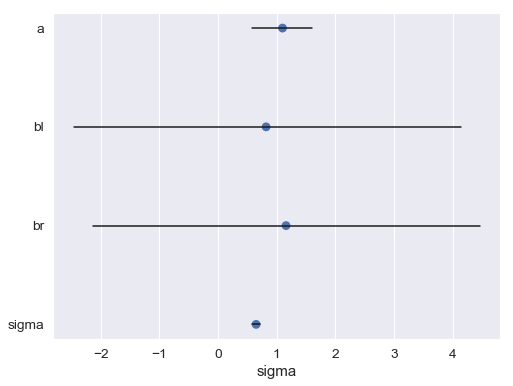

In [32]:
precis_df = precis(m5_8)
sns.pointplot(precis_df["Mean"], precis_df.index, join=False)
for i, node in enumerate(precis_df.index):
    sns.lineplot(precis_df.loc[node, ["|0.89", "0.89|"]], [i, i], color="k")

### Code 5.32

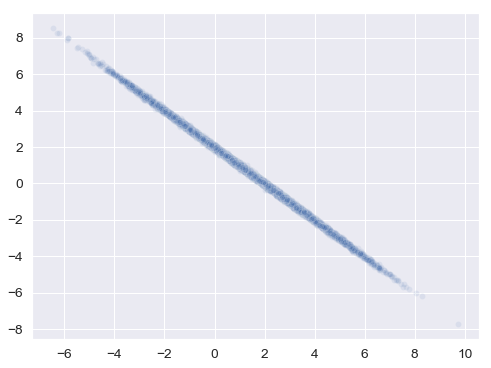

In [33]:
post = extract_samples(m5_8)
sns.scatterplot("br", "bl", data=post, alpha=0.1);

### Code 5.33

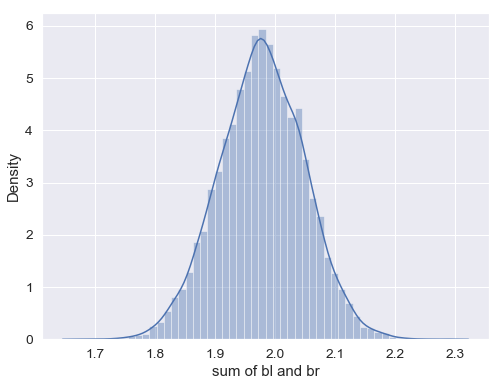

In [34]:
sum_blbr = post["bl"] + post["br"]
ax = sns.distplot(sum_blbr)
ax.set(xlabel="sum of bl and br", ylabel="Density");

### Code 5.34

In [35]:
def model(leg_left, height):
    a = pyro.sample("a", dist.Normal(10, 100))
    bl = pyro.sample("bl", dist.Normal(2, 10))
    mu = a + bl * leg_left
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_9 = MAP(model).run(leg_left, height)
precis(m5_9)

,Mean,StdDev,|0.89,0.89|
a,1.09,0.32,0.57,1.60
bl,1.98,0.07,1.86,2.09
sigma,0.65,0.05,0.58,0.73


### Code 5.35

In [36]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk

### Code 5.36

In [37]:
# kcal.per.g regressed on perc.fat
def model(perc_fat, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    bf = pyro.sample("bf", dist.Normal(0, 1))
    mu = a + bf * perc_fat
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

perc_fat = torch.tensor(d["perc.fat"], dtype=torch.float)
kcal_per_g = torch.tensor(d["kcal.per.g"], dtype=torch.float)
m5_10 = MAP(model).run(perc_fat, kcal_per_g)

# kcal.per.g regressed on perc.lactose
def model(perc_lactose, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    bl = pyro.sample("bf", dist.Normal(0, 1))
    mu = a + bl * perc_lactose
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

perc_lactose = torch.tensor(d["perc.lactose"], dtype=torch.float)
m5_11 = MAP(model).run(perc_lactose, kcal_per_g)

print(precis(m5_10, digits=3))
print(precis(m5_11, digits=3))

        Mean  StdDev  |0.89  0.89|
a      0.302   0.037  0.243  0.360
bf     0.010   0.001  0.008  0.012
sigma  0.075   0.010  0.059  0.091
        Mean  StdDev  |0.89  0.89|
a      1.166   0.043  1.095  1.232
bf    -0.011   0.001 -0.012 -0.009
sigma  0.063   0.008  0.050  0.077


### Code 5.37

In [38]:
def model(perc_fat, perc_lactose, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    bf = pyro.sample("bf", dist.Normal(0, 1))
    bl = pyro.sample("bl", dist.Normal(0, 1))
    mu = a + bf * perc_fat + bl * perc_lactose
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_12 = MAP(model).run(perc_fat, perc_lactose, kcal_per_g)
precis(m5_12, digits=3)

,Mean,StdDev,|0.89,0.89|
a,1.005,0.203,0.678,1.328
bf,0.002,0.002,-0.002,0.006
bl,-0.009,0.002,-0.013,-0.005
sigma,0.063,0.008,0.050,0.076


### Code 5.38

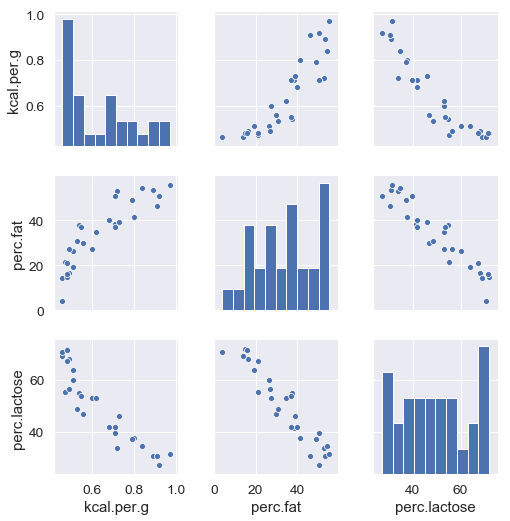

In [39]:
sns.pairplot(d[["kcal.per.g", "perc.fat", "perc.lactose"]]);

### Code 5.39

In [40]:
perc_fat_s = (perc_fat - perc_fat.mean()) / perc_fat.std()
perc_lactose_s = (perc_lactose - perc_lactose.mean()) / perc_lactose.std()
perc_fat_s.dot(perc_lactose_s) / (perc_fat_s.size(0) - 1)

tensor(-0.9416)

### Code 5.40

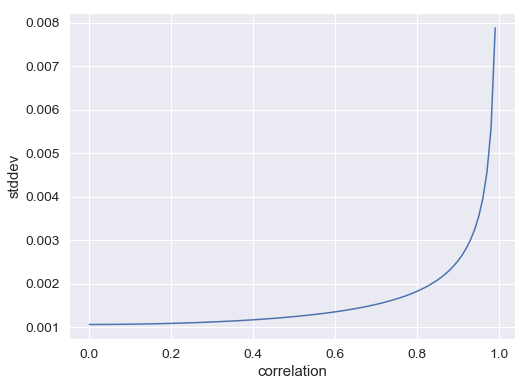

In [41]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
m = LM("kcal.per.g ~ perc.fat", data=d, num_samples=100)
m.model = pyro.do(m.model, data={"sigma": 1})
m.run()
perc_fat = torch.tensor(d["perc.fat"], dtype=torch.float)
kcal_per_g = torch.tensor(d["kcal.per.g"], dtype=torch.float)
resid = kcal_per_g - (coef(m)["Intercept"] + coef(m)["perc.fat"] * perc_fat)
sigma = resid.std()
perc_fat_var = perc_fat.var()

def sim_coll(r=0.9):
    d["x"] = dist.Normal(loc=(r * perc_fat),
                         scale=((1 - r**2) * perc_fat_var).sqrt()).sample()
    m = LM("kcal.per.g ~ perc.fat + x", data=d, num_samples=10)
    m.model = pyro.do(m.model, data={"sigma": sigma})
    m.run()
    return vcov(m).diag().sqrt()[1]  # stddev of parameter

def rep_sim_coll(r=0.9, n=100):
    stddev = replicate(n, sim_coll, (r,))
    return torch.stack(stddev).mean()

r_seq = torch.arange(start=0, end=1, step=0.01)
stddev = torch.stack([rep_sim_coll(r=z, n=100) for z in r_seq])
ax = sns.lineplot(r_seq, stddev)
ax.set(xlabel="correlation", ylabel="stddev");

### Code 5.41

In [42]:
# number of plants
N = 100

# simulate initial heights
h0 = torch.empty(N).normal_(10, 2)

# assign treatments and simulate fungus and growth
treatment = torch.arange(2.).unsqueeze(1).repeat(1, N // 2).reshape(-1)
fungus = dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4)).sample()
h1 = h0 + dist.Normal(5 - 3 * fungus, 1).sample()

# compose a clean data dict
d = {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}

### Code 5.42

In [43]:
def model(h0, treatment, fungus, h1):
    a = pyro.sample("a", dist.Normal(0, 100))
    bh = pyro.sample("bh", dist.Normal(0, 10))
    bt = pyro.sample("bt", dist.Normal(0, 10))
    bf = pyro.sample("bf", dist.Normal(0, 10))
    mu = a + bh * h0 + bt * treatment + bf * fungus
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m5_13 = MAP(model).run(**d)
precis(m5_13)

,Mean,StdDev,|0.89,0.89|
a,5.02,0.44,4.32,5.72
bh,0.99,0.04,0.93,1.06
bt,-0.00,0.21,-0.34,0.34
bf,-3.05,0.23,-3.41,-2.70
sigma,0.98,0.07,0.87,1.09


### Code 5.43

In [44]:
def model(h0, treatment, h1):
    a = pyro.sample("a", dist.Normal(0, 100))
    bh = pyro.sample("bh", dist.Normal(0, 10))
    bt = pyro.sample("bt", dist.Normal(0, 10))
    mu = a + bh * h0 + bt * treatment
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m5_14 = MAP(model).run(h0, treatment, h1)
precis(m5_14)

,Mean,StdDev,|0.89,0.89|
a,4.21,0.74,3.02,5.37
bh,0.91,0.07,0.80,1.03
bt,1.13,0.33,0.58,1.64
sigma,1.66,0.12,1.47,1.84


### Code 5.44

In [45]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 5.45

In [46]:
def model(male, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    bm = pyro.sample("bm", dist.Normal(0, 10))
    mu = a + bm * male
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

male = torch.tensor(d["male"], dtype=torch.float)
height = torch.tensor(d["height"], dtype=torch.float)
m5_15 = MAP(model).run(male, height)
precis(m5_15)

,Mean,StdDev,|0.89,0.89|
a,134.82,1.59,132.36,137.43
bm,7.27,2.29,3.72,11.00
sigma,27.30,0.82,25.91,28.53


### Code 5.46

In [47]:
post = extract_samples(m5_15)
mu_male = post["a"] + post["bm"]
stats.pi(mu_male, 0.89)

tensor([139.4144, 144.7264])

### Code 5.47

In [48]:
def model(male, height):
    af = pyro.sample("af", dist.Normal(178, 100))
    am = pyro.sample("am", dist.Normal(178, 100))
    mu = af * (1 - male) + am * male
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_15b = MAP(model).run(male, height)

### Code 5.48

In [49]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["clade"].unique().tolist()

['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape']

### Code 5.49

In [50]:
clade_NWM = torch.tensor(d["clade"] == "New World Monkey", dtype=torch.float)
clade_NWM

tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Code 5.50

In [51]:
clade_OWM = torch.tensor(d["clade"] == "Old World Monkey", dtype=torch.float)
clade_S = torch.tensor(d["clade"] == "Strepsirrhine", dtype=torch.float)

### Code 5.51

In [52]:
def model(clade_NWM, clade_OWM, clade_S, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    b_NWM = pyro.sample("b.NWM", dist.Normal(0, 1))
    b_OWM = pyro.sample("b.OWM", dist.Normal(0, 1))
    b_S = pyro.sample("b.S", dist.Normal(0, 1))
    mu = a + b_NWM * clade_NWM + b_OWM * clade_OWM + b_S * clade_S
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

kcal_per_g = torch.tensor(d["kcal.per.g"], dtype=torch.float)
m5_16 = MAP(model).run(clade_NWM, clade_OWM, clade_S, kcal_per_g)
precis(m5_16)

,Mean,StdDev,|0.89,0.89|
a,0.55,0.04,0.48,0.61
b.NWM,0.17,0.05,0.08,0.25
b.OWM,0.24,0.06,0.15,0.34
b.S,-0.04,0.06,-0.14,0.07
sigma,0.12,0.02,0.09,0.14


### Code 5.52

In [53]:
# sample posterior
post = extract_samples(m5_16)

# compute averages for each category
mu_ape = post["a"]
mu_NWM = post["a"] + post["b.NWM"]
mu_OWM = post["a"] + post["b.OWM"]
mu_S = post["a"] + post["b.S"]

# summarize using precis
precis({"mu.ape": mu_ape, "mu.NWM": mu_NWM, "mu.OWM": mu_OWM, "mu.S": mu_S})

,Mean,StdDev,|0.89,0.89|
mu.ape,0.55,0.04,0.48,0.61
mu.NWM,0.71,0.04,0.65,0.77
mu.OWM,0.79,0.05,0.72,0.87
mu.S,0.51,0.05,0.43,0.59


### Code 5.53

In [54]:
diff_NWM_OWM = mu_NWM - mu_OWM
stats.quantile(diff_NWM_OWM, probs=(0.025, 0.5, 0.975))

tensor([-0.1938, -0.0733,  0.0447])

### Code 5.54

In [55]:
clade_id = torch.tensor(d["clade"].astype("category").cat.codes, dtype=torch.long)
clade_id

tensor([3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

### Code 5.55

In [56]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["clade"].unique().tolist()
kcal_per_g = torch.tensor(d["kcal.per.g"], dtype=torch.float)
clade_id = torch.tensor(d["clade"].astype("category").cat.codes, dtype=torch.long)
def model(clade_id, kcal_per_g):
    with pyro.plate("plate_a", clade_id.unique().size(0)):
        a = pyro.sample("a", dist.Normal(0.6, 10))
    mu = a[clade_id]
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_16_alt = MAP(model).run(clade_id, kcal_per_g)
precis(m5_16_alt)

,Mean,StdDev,|0.89,0.89|
a[0],0.55,0.04,0.48,0.61
a[1],0.71,0.04,0.65,0.78
a[2],0.79,0.05,0.71,0.86
a[3],0.51,0.05,0.43,0.59
sigma,0.12,0.02,0.09,0.14


### Code 5.56

```python
m5_17 = LM("y ~ 1 + x", data=d).run()
m5_18 = LM("y ~ 1 + x + z + w", data=d).run()
```

### Code 5.57

```python
m5_17 = LM("y ~ 1 + x", data=d).run()
m5_19 = LM("y ~ x", data=d).run()
```

### Code 5.58

```python
m5_20 = LM("y ~ 0 + x", data=d).run()
m5_21 = LM("y ~ x + 0", data=d).run()
```

### Code 5.59

```python
m5_22 = LM("y ~ 1 + C(season)", data=d).run()
```

### Code 5.60

```python
d["x2"] = d["x"] ** 2
d["x3"] = d["x"] ** 3
m5_23 = LM("y ~ 1 + x + x2 + x3", data=d).run()
```

### Code 5.61

```python
m5_24 = LM("y ~ 1 + x + I(x ** 2) + I(x ** 3)", data=d).run()
```

### Code 5.62

In [57]:
cars = pd.read_csv("../data/cars.csv")
glimmer("dist ~ speed", data=cars)

def model(speed, dist):
    intercept = pyro.sample('Intercept', dist.Normal(0, 10))
    b_speed = pyro.sample('speed', dist.Normal(0, 10))
    mu = intercept + b_speed * speed
    sigma = pyro.sample('sigma', dist.HalfCauchy(2))
    with pyro.plate('plate'):
        return pyro.sample('dist', dist.Normal(mu, sigma), obs=dist)
